In [1]:
import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.data_preprocessing import datetime_processing, userinput_processing, holiday_processing, create_x, create_y, create_wide_y
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
tf.random.set_seed(42)

2024-03-08 12:40:37.732775: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os
os.chdir('/Users/varunvenkatesh/Documents/Github/ev_charging')
os.getcwd()

'/Users/varunvenkatesh/Documents/GitHub/ev_charging'

In [3]:
df = pd.read_parquet('data/sessions/caltech/').reset_index(drop=True)
df = datetime_processing(df)
df = userinput_processing(df)
df = holiday_processing(df)

In [4]:
df.head()

,_id,sessionID,stationID,spaceID,siteID,clusterID,connectionTime,disconnectTime,kWhDelivered,doneChargingTime,...,doneChargingTimeDay,userID,milesRequested,WhPerMile,minutesAvailable,modifiedAt,paymentRequired,requestedDeparture,kWhRequested,is_holiday
0,5bc9160af9af8b0dad3c0690,2_39_95_27_2018-05-01 13:23:18.374684,2-39-95-27,CA-319,2,39,2018-05-01 13:23:18+00:00,2018-05-02 01:53:41+00:00,13.410,2018-05-01 17:17:07+00:00,...,1.0,NaN,NaN,NaN,NaN,None,None,None,NaN,False
1,5bc9160af9af8b0dad3c0691,2_39_79_380_2018-05-01 13:54:33.599590,2-39-79-380,CA-489,2,39,2018-05-01 13:54:34+00:00,2018-05-01 23:15:35+00:00,8.618,2018-05-01 15:35:39+00:00,...,1.0,NaN,NaN,NaN,NaN,None,None,None,NaN,False
2,5bc9160af9af8b0dad3c0692,2_39_139_28_2018-05-01 14:46:04.441389,2-39-139-28,CA-303,2,39,2018-05-01 14:46:04+00:00,2018-05-02 00:54:07+00:00,13.969,2018-05-01 23:57:02+00:00,...,1.0,NaN,NaN,NaN,NaN,None,None,None,NaN,False
3,5bc9160af9af8b0dad3c0693,2_39_79_378_2018-05-01 14:56:28.908623,2-39-79-378,CA-326,2,39,2018-05-01 14:56:29+00:00,2018-05-01 21:52:45+00:00,6.914,2018-05-01 16:07:56+00:00,...,1.0,NaN,NaN,NaN,NaN,None,None,None,NaN,False
4,5bc9160af9af8b0dad3c0694,2_39_88_24_2018-05-01 15:14:50.443137,2-39-88-24,CA-314,2,39,2018-05-01 15:14:50+00:00,2018-05-01 22:51:30+00:00,13.785,2018-05-01 20:18:12+00:00,...,1.0,NaN,NaN,NaN,NaN,None,None,None,NaN,False


In [5]:
df.stationID.value_counts()

2-39-139-28     1792
2-39-131-30     1399
2-39-129-17     1136
2-39-81-4550    1126
2-39-89-25      1086
2-39-125-21     1042
2-39-127-19     1022
2-39-138-29      994
2-39-79-379      932
2-39-123-23      908
2-39-79-380      892
2-39-78-365      862
2-39-91-437      846
2-39-79-377      820
2-39-130-31      789
2-39-78-366      759
2-39-95-27       737
2-39-88-24       694
2-39-79-383      683
2-39-124-22      665
2-39-79-378      645
2-39-78-363      615
2-39-128-18      612
2-39-79-381      587
2-39-79-376      581
2-39-78-360      578
2-39-90-26       567
2-39-126-20      561
2-39-92-436      558
2-39-78-367      533
2-39-78-361      529
2-39-79-382      506
2-39-92-442      503
2-39-78-364      458
2-39-91-441      452
2-39-78-362      452
2-39-90-440      432
2-39-95-444      396
2-39-88-438      332
2-39-89-439      330
2-39-123-557     247
2-39-83-386      200
2-39-138-566     175
2-39-124-558     149
2-39-130-564     136
2-39-126-560     124
2-39-128-562     120
2-39-139-567 

In [6]:
def get_results(y_test, prediction):
    cm = confusion_matrix(y_test,prediction)
    make_classification_plot(cm)
    
    results = {'tpr': cm[1, 1]/np.sum(cm[1]),
               'fpr': cm[0,1]/np.sum(cm[0]),
               'accuracy': accuracy_score(y_test, prediction),
               'precision': precision_score(y_test, prediction),
               'recall': recall_score(y_test, prediction),
        'f1':f1_score(y_test,prediction)}
    return results

In [7]:
def make_classification_plot(cm):
    disp = ConfusionMatrixDisplay(cm)
    disp = disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
    plt.grid(False)
    plt.show()

In [8]:
results = {}

In [9]:
# create x and y 
start = '2018-05-01'
end = '2021-09-13'
spaceID = 'CA-303'
caiso_fp = 'data/caiso_dataset_5min.csv'
sun_fp = 'data/ct_sr_ss.csv'

In [10]:
X = create_x(start, end, caiso_fp, sun_fp)
y = create_y(df, start, end, spaceID)

In [11]:
X.head(30)

,dow,hour,month,is_sunny,is_holiday,Day ahead forecast,Hour ahead forecast,Current demand,Net demand,Solar,...,Large hydro,Batteries,Imports,Other,Biogas CO2,Biomass CO2,Natural Gas CO2,Coal CO2,Imports CO2,Geothermal CO2
2018-05-01 00:00:00+00:00,1,0,5,0,False,21013.666667,21496.500000,21378.500000,17906.000000,0.000000,...,2079.000000,-10.500000,8085.166667,0.0,136.083333,151.083333,1945.250000,17.833333,3824.166667,9.083333
2018-05-01 01:00:00+00:00,1,1,5,0,False,20133.083333,20673.916667,20644.583333,17251.333333,0.000000,...,2084.333333,8.083333,7786.083333,0.0,140.666667,153.416667,1774.666667,17.416667,3820.750000,10.000000
2018-05-01 02:00:00+00:00,1,2,5,0,False,19582.666667,20174.083333,20089.166667,16399.916667,0.000000,...,1948.416667,-18.250000,7026.916667,0.0,140.916667,154.916667,1791.166667,15.833333,3458.500000,10.000000
2018-05-01 03:00:00+00:00,1,3,5,0,False,19423.500000,19905.083333,19822.250000,15958.416667,0.000000,...,1987.833333,-21.833333,6644.833333,0.0,140.916667,157.166667,1770.250000,16.416667,3257.000000,10.000000
2018-05-01 04:00:00+00:00,1,4,5,0,False,19879.583333,20325.833333,20321.166667,16600.583333,0.000000,...,2287.750000,-8.083333,6972.083333,0.0,140.666667,153.500000,1802.416667,17.166667,3387.916667,10.000000
2018-05-01 05:00:00+00:00,1,5,5,0,False,21337.333333,21718.916667,21718.666667,18034.833333,0.000000,...,2660.583333,-31.166667,7790.583333,0.0,137.166667,150.333333,1890.250000,15.583333,3677.750000,9.083333
2018-05-01 06:00:00+00:00,1,6,5,0,False,23149.000000,23605.916667,23639.250000,19678.416667,391.500000,...,2771.166667,0.083333,8815.500000,0.0,135.000000,149.750000,2035.750000,17.416667,4102.166667,9.000000
2018-05-01 07:00:00+00:00,1,7,5,1,False,24480.833333,25012.750000,24989.333333,18528.916667,3088.416667,...,2787.333333,-29.416667,7865.666667,0.0,134.166667,151.500000,1949.083333,17.166667,3744.666667,9.000000
2018-05-01 08:00:00+00:00,1,8,5,1,False,24527.500000,25217.166667,25220.916667,16230.166667,5764.083333,...,2472.833333,-4.250000,6099.833333,0.0,136.500000,156.250000,1851.333333,18.500000,2983.166667,9.666667
2018-05-01 09:00:00+00:00,1,9,5,1,False,24332.250000,25026.916667,25010.250000,15238.083333,6660.416667,...,2301.666667,13.833333,5802.583333,0.0,138.833333,159.416667,1666.333333,19.500000,2852.666667,10.000000


In [12]:
print(f'charger CA-303 is available {np.round(y.mean()*100,3)}% of the time')

charger CA-303 is available is_available    69.964
dtype: float64% of the time


In [13]:
#X.fillna(0.0, inplace=True)

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29545 entries, 2018-05-01 00:00:00+00:00 to 2021-09-13 00:00:00+00:00
Freq: H
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dow                  29545 non-null  int64  
 1   hour                 29545 non-null  int64  
 2   month                29545 non-null  int64  
 3   is_sunny             29545 non-null  int64  
 4   is_holiday           29545 non-null  bool   
 5   Day ahead forecast   29545 non-null  float64
 6   Hour ahead forecast  29545 non-null  float64
 7   Current demand       29545 non-null  float64
 8   Net demand           29545 non-null  float64
 9   Solar                29545 non-null  float64
 10  Wind                 29545 non-null  float64
 11  Geothermal           29545 non-null  float64
 12  Biomass              29545 non-null  float64
 13  Biogas               29545 non-null  float64
 14  Small hydro          29545 non-

In [15]:
X.shape[0] == y.shape[0]

True

## Binary Forecasting

# LSTM

In [16]:
# Create hold out test set
bin_numbers = pd.qcut(y['is_available'], q=10, labels=False, duplicates='drop')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, stratify=bin_numbers, random_state=42)
print(f'the training data has an average availability of {np.round(y_train.mean()*100,3)}%')

the training data has an average availability of is_available    69.652
dtype: float64%


In [17]:
type(X_train)

pandas.core.frame.DataFrame

In [18]:
df_PCA = pd.DataFrame(X_train)
scaler = StandardScaler()
scaler.fit(df_PCA)
scaled_data = scaler.transform(df_PCA)
principal=PCA(n_components=10)
principal.fit(scaled_data)
print(principal.explained_variance_ratio_)

[0.23443041 0.13137683 0.1202225  0.08296788 0.06131921 0.05310063
 0.04520548 0.0374053  0.03650787 0.03607821]


In [19]:
train_scaler = StandardScaler()
test_scaler = StandardScaler()

In [20]:
X_train_LSTM = pd.DataFrame(train_scaler.fit_transform(X_train))
X_test_LSTM = pd.DataFrame(test_scaler.fit_transform(X_test))

In [21]:
lstm_model = Sequential()
lstm_model.add(LSTM(4, input_shape=(1, X_train_LSTM.shape[1])))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

2024-03-08 12:41:24.543178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
X_train_LSTM = np.reshape(X_train_LSTM.values.astype(float), (X_train_LSTM.shape[0], 1, X_train_LSTM.shape[1]))
X_test_LSTM = np.reshape(X_test_LSTM.values.astype(float), (X_test_LSTM.shape[0], 1, X_test_LSTM.shape[1]))

In [23]:
[print(i.shape, i.dtype) for i in lstm_model.inputs]
[print(o.shape, o.dtype) for o in lstm_model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in lstm_model.layers]

(None, 1, 28) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
lstm (None, 1, 28) float32
dense (None, 4) float32


[None, None]

In [24]:
X_train.shape

(23636, 28)

In [25]:
y_train = y_train.drop('sessionID', axis=1) 
y_test = y_test.drop('sessionID', axis=1)

In [26]:
lstm_model.fit(X_train_LSTM, y_train, epochs=10, batch_size=8, verbose=2)

Epoch 1/10
2955/2955 - 15s - loss: 0.2065 - 15s/epoch - 5ms/step
Epoch 2/10
2955/2955 - 11s - loss: 0.1709 - 11s/epoch - 4ms/step
Epoch 3/10
2955/2955 - 9s - loss: 0.1666 - 9s/epoch - 3ms/step
Epoch 4/10
2955/2955 - 9s - loss: 0.1641 - 9s/epoch - 3ms/step
Epoch 5/10
2955/2955 - 10s - loss: 0.1627 - 10s/epoch - 3ms/step
Epoch 6/10
2955/2955 - 10s - loss: 0.1617 - 10s/epoch - 3ms/step
Epoch 7/10
2955/2955 - 9s - loss: 0.1608 - 9s/epoch - 3ms/step
Epoch 8/10
2955/2955 - 9s - loss: 0.1602 - 9s/epoch - 3ms/step
Epoch 9/10
2955/2955 - 10s - loss: 0.1594 - 10s/epoch - 3ms/step
Epoch 10/10
2955/2955 - 9s - loss: 0.1587 - 9s/epoch - 3ms/step


In [27]:
predictions = lstm_model.predict(X_test_LSTM)

185/185 [==============================] - 1s 2ms/step


In [28]:
# MSE with CAISO
score = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {score}')

Mean Squared Error: 0.16636845621515267


# XGBoost

In [31]:
X_train = np.reshape(X_train.astype(float), (X_train.shape[0], X_train.shape[1]))
X_test = np.reshape(X_test.astype(float), (X_test.shape[0], X_test.shape[1]))

In [32]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [33]:
predictions = model.predict(X_test)

In [34]:
score = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {score}')

Mean Squared Error: 0.15349466914875615


In [35]:
y_pred = predictions
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[1155  546]
 [ 361 3847]]


0.8465053308512439

## Multinomial Forecasting

# LSTM

In [36]:
y = create_wide_y(df, start, end)

In [37]:
y = y.sum(axis=1)

In [38]:
y.head()

2018-05-01 00:00:00+00:00    55
2018-05-01 01:00:00+00:00    55
2018-05-01 02:00:00+00:00    55
2018-05-01 03:00:00+00:00    55
2018-05-01 04:00:00+00:00    55
Freq: H, dtype: int64

In [39]:
# Create hold out test set
bin_numbers = pd.qcut(y, q=10, labels=False, duplicates='drop')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, stratify=bin_numbers, random_state=42)
print(f'the training data has an average availability of {np.round(y_train.mean(),3)} spots available')

the training data has an average availability of 49.038 spots available


In [40]:
train_scaler = StandardScaler()
test_scaler = StandardScaler()
X_train_LSTM = pd.DataFrame(train_scaler.fit_transform(X_train))
X_test_LSTM = pd.DataFrame(test_scaler.fit_transform(X_test))

In [41]:
lstm_model = Sequential()
lstm_model.add(LSTM(4, input_shape=(1, X_train_LSTM.shape[1])))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

In [42]:
X_train_LSTM = np.reshape(X_train_LSTM.values.astype(float), (X_train_LSTM.shape[0], 1, X_train_LSTM.shape[1]))
X_test_LSTM = np.reshape(X_test_LSTM.values.astype(float), (X_test_LSTM.shape[0], 1, X_test_LSTM.shape[1]))

In [43]:
[print(i.shape, i.dtype) for i in lstm_model.inputs]
[print(o.shape, o.dtype) for o in lstm_model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in lstm_model.layers]

(None, 1, 28) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
lstm_1 (None, 1, 28) float32
dense_1 (None, 4) float32


[None, None]

In [44]:
lstm_model.fit(X_train_LSTM, y_train, epochs=10, batch_size=8, verbose=2)

Epoch 1/10
2955/2955 - 50s - loss: 1932.7328 - 50s/epoch - 17ms/step
Epoch 2/10
2955/2955 - 15s - loss: 916.8024 - 15s/epoch - 5ms/step
Epoch 3/10
2955/2955 - 18s - loss: 418.5625 - 18s/epoch - 6ms/step
Epoch 4/10
2955/2955 - 37s - loss: 162.9379 - 37s/epoch - 12ms/step
Epoch 5/10
2955/2955 - 28s - loss: 69.2312 - 28s/epoch - 9ms/step
Epoch 6/10
2955/2955 - 20s - loss: 50.3487 - 20s/epoch - 7ms/step
Epoch 7/10
2955/2955 - 17s - loss: 44.8593 - 17s/epoch - 6ms/step
Epoch 8/10
2955/2955 - 11s - loss: 40.7662 - 11s/epoch - 4ms/step
Epoch 9/10
2955/2955 - 10s - loss: 38.2748 - 10s/epoch - 4ms/step
Epoch 10/10
2955/2955 - 10s - loss: 36.8278 - 10s/epoch - 3ms/step


In [45]:
predictions = lstm_model.predict(X_test_LSTM)

185/185 [==============================] - 1s 2ms/step


In [46]:
score = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {score}')

Mean Squared Error: 48.56465976190438


In [91]:
y_pred = pd.Series(predictions, index=X_test.index)

array([47, 44, 50, ..., 50, 19, 50])

<AxesSubplot: >

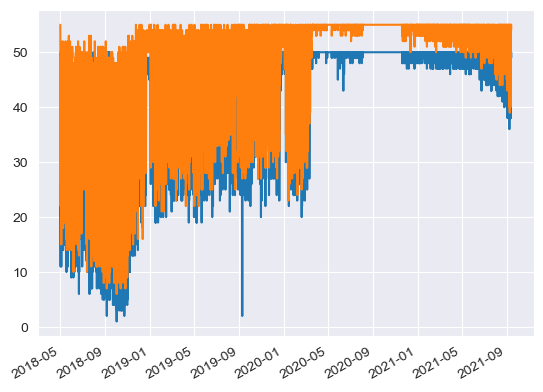

In [98]:
y_pred = pd.Series(predictions, index=X_test.index).sort_index()
y_pred.plot()
y_test = y_test.sort_index()
y_test.plot()

<AxesSubplot: >

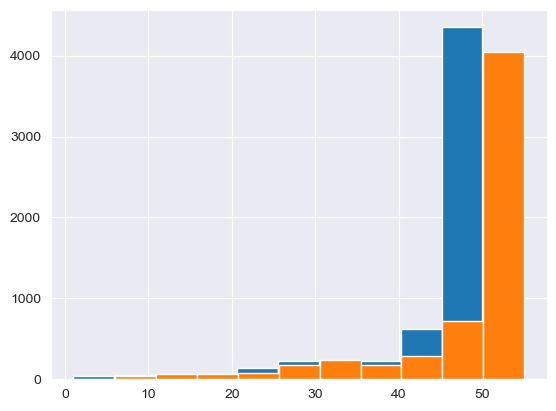

In [99]:
y_pred.hist()
y_test.hist()

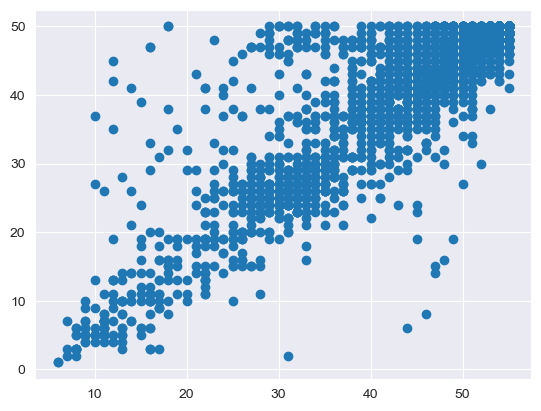

In [87]:
plt.scatter(y_test, predictions)

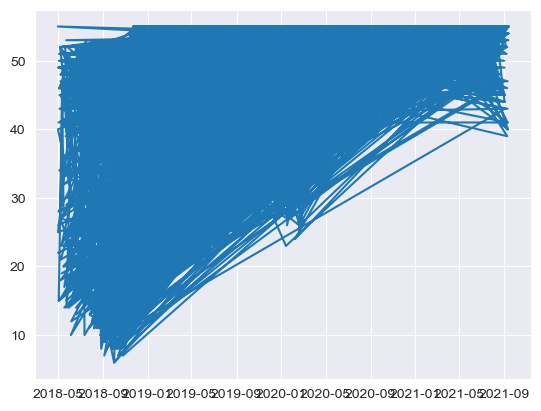

In [88]:
plt.plot(y_test.index, y_test)

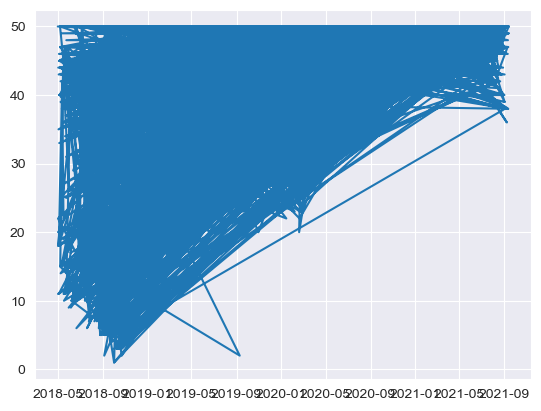

In [89]:
plt.plot(y_test.index, predictions)

In [90]:
y_test

2021-05-26 19:00:00+00:00    52
2018-09-24 12:00:00+00:00    48
2020-06-17 16:00:00+00:00    55
2021-05-16 19:00:00+00:00    54
2019-08-18 14:00:00+00:00    55
                             ..
2020-11-05 03:00:00+00:00    55
2019-09-29 00:00:00+00:00    55
2020-07-19 19:00:00+00:00    53
2018-11-17 00:00:00+00:00    29
2020-11-03 22:00:00+00:00    55
Length: 5909, dtype: int64

# XGBoost

In [48]:
X_train = np.reshape(X_train.astype(float), (X_train.shape[0], X_train.shape[1]))
X_test = np.reshape(X_test.astype(float), (X_test.shape[0], X_test.shape[1]))

In [49]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [50]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [51]:
predictions = model.predict(X_test)

In [52]:
score = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {score}')

Mean Squared Error: 33.928245049923845


In [53]:
y_pred = le.inverse_transform(predictions)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[   2    0    0 ...    0    0    0]
 [   0    1    1 ...    0    0    0]
 [   0    1    5 ...    0    0    0]
 ...
 [   0    0    0 ...  250  167   93]
 [   0    0    0 ...  119  447  255]
 [   0    0    0 ...   44  177 1744]]


0.48908444745303775

# Optuna

In [54]:
import optuna 
import xgboost as xgb

In [55]:
def objective(trial):
    
  bin_numbers = pd.qcut(y, q=10, labels=False, duplicates='drop')
  train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size = .2, stratify=bin_numbers, random_state=42)
  train_y = le.fit_transform(train_y)
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  max_depth = trial.suggest_int("max_depth", 2, 10,step=2, log=False)
  n_estimators = trial.suggest_int("n_estimators", 200, 500,step=100, log=False)

  model = XGBClassifier(objective= 'multi:softprob',
                        learning_rate = learning_rate,
                        n_estimators = n_estimators,
                        max_depth = max_depth,
                        seed=42)

  model.fit(train_x, train_y)

  y_pred = le.inverse_transform(model.predict(valid_x))
  accuracy = accuracy_score(valid_y, y_pred)

  # Handle pruning based on the intermediate value.
  if trial.should_prune():
    raise optuna.exceptions.TrialPruned()

  trial.set_user_attr(key="best_model", value=model) # save model
  return accuracy

# callback function to save the best model as user attribute
def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_model", value=trial.user_attrs["best_model"])

In [57]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600, callbacks=[callback])

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-03-08 12:52:23,317] A new study created in memory with name: no-name-dc5f0648-024d-4582-9270-5dc225b2d90b
[I 2024-03-08 12:53:47,556] Trial 0 finished with value: 0.3674056523946522 and parameters: {'learning_rate': 2.528692856375997e-05, 'max_depth': 4, 'n_estimators': 400}. Best is trial 0 with value: 0.3674056523946522.
[I 2024-03-08 12:54:59,249] Trial 1 finished with value: 0.35843628363513286 and parameters: {'learning_rate': 0.0028350843164575085, 'max_depth': 2, 'n_estimators': 500}. Best is trial 0 with value: 0.3674056523946522.
[I 2024-03-08 12:59:32,050] Trial 2 finished with value: 0.41496023015738703 and parameters: {'learning_rate': 1.9823048214380852e-05, 'max_depth': 10, 'n_estimators': 400}. Best is trial 2 with value: 0.41496023015738703.
[I 2024-03-08 13:05:16,133] Trial 3 finished with value: 0.4180064308681672 and parameters: {'learning_rate': 2.00108053866363e-05, 'max_depth': 10, 'n_estimators': 500}. Best is trial 3 with value: 0.4180064308681672.


Number of finished trials:  4
Best trial:
  Value: 0.4180064308681672
  Params: 
    learning_rate: 2.00108053866363e-05
    max_depth: 10
    n_estimators: 500


In [81]:
def lstm_objective(trial):
    
  bin_numbers = pd.qcut(y, q=10, labels=False, duplicates='drop')
  train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size = .2, stratify=bin_numbers, random_state=42)
  
  train_scaler = StandardScaler()
  test_scaler = StandardScaler()
  X_train_LSTM = pd.DataFrame(train_scaler.fit_transform(train_x))
  X_test_LSTM = pd.DataFrame(test_scaler.fit_transform(valid_x))
  
  # tunable params
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  n_layers = trial.suggest_int("n_layers", 1, 4)
  n_units = trial.suggest_int("n_units", 4, 64)
  activation = trial.suggest_categorical("activation", ["relu", "selu", "elu", "swish"])
  dropout_rate = trial.suggest_float("lstm_dropout", 0.0, 0.3)
  
  # create model
  x0 = tf.keras.Input(shape=(1, X_train_LSTM.shape[1]))

  lstm_units = np.zeros(n_layers, dtype=int)
  #lstm_units[0] = trial.suggest_int("n_units_L1", 4, 64)
  lstm = LSTM(n_units, input_shape=(1, X_train_LSTM.shape[1]), return_sequences=True)(x0)
  for i in range(1, n_layers):
    #lstm_units[i] = trial.suggest_int(f"n_units_L{i+1}", 4, 64)
    lstm = LSTM(n_units, return_sequences=True)(lstm)
    lstm = Dropout(dropout_rate)(lstm)

  #dense_units = lstm_units[-1]
  lstm = Dense(n_units, activation=activation)(lstm)
  lstm = Dense(1)(lstm)
  model = tf.keras.Model(inputs=x0, outputs=lstm)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
  
  [print(i.shape, i.dtype) for i in model.inputs]
  [print(o.shape, o.dtype) for o in model.outputs]
  [print(l.name, l.input_shape, l.dtype) for l in model.layers]
  
  X_train_LSTM = np.reshape(X_train_LSTM.values.astype(float), (X_train_LSTM.shape[0], 1, X_train_LSTM.shape[1]))
  X_test_LSTM = np.reshape(X_test_LSTM.values.astype(float), (X_test_LSTM.shape[0], 1, X_test_LSTM.shape[1]))
  
  model.fit(X_train_LSTM, train_y, epochs=10, batch_size=8, verbose=2)
  
  y_pred = model.predict(X_test_LSTM)
  score = mean_squared_error(valid_y, y_pred.flatten())

  # Handle pruning based on the intermediate value.
  if trial.should_prune():
    raise optuna.exceptions.TrialPruned()

  trial.set_user_attr(key="best_model", value=model) # save model
  return score

# callback function to save the best model as user attribute
def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_model", value=trial.user_attrs["best_model"])

In [82]:
study = optuna.create_study(direction="minimize")
study.optimize(lstm_objective, n_trials=100, timeout=600, callbacks=[callback])

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-03-08 14:30:34,305] A new study created in memory with name: no-name-56c9df38-a718-4dc6-9f53-9bd45dc5431f


(None, 1, 28) <dtype: 'float32'>
(None, 1, 1) <dtype: 'float32'>
input_12 [(None, 1, 28)] float32
lstm_24 (None, 1, 28) float32
lstm_25 (None, 1, 24) float32
dropout_11 (None, 1, 24) float32
lstm_26 (None, 1, 24) float32
dropout_12 (None, 1, 24) float32
lstm_27 (None, 1, 24) float32
dropout_13 (None, 1, 24) float32
dense_22 (None, 1, 24) float32
dense_23 (None, 1, 24) float32
Epoch 1/10
2955/2955 - 20s - loss: 74.9564 - 20s/epoch - 7ms/step
Epoch 2/10
2955/2955 - 14s - loss: 48.0925 - 14s/epoch - 5ms/step
Epoch 3/10
2955/2955 - 16s - loss: 44.3788 - 16s/epoch - 6ms/step
Epoch 4/10
2955/2955 - 28s - loss: 41.3256 - 28s/epoch - 9ms/step
Epoch 5/10
2955/2955 - 35s - loss: 38.6090 - 35s/epoch - 12ms/step
Epoch 6/10
2955/2955 - 43s - loss: 35.2107 - 43s/epoch - 14ms/step
Epoch 7/10
2955/2955 - 38s - loss: 32.6531 - 38s/epoch - 13ms/step
Epoch 8/10
2955/2955 - 28s - loss: 33.4627 - 28s/epoch - 10ms/step
Epoch 9/10
2955/2955 - 25s - loss: 32.3837 - 25s/epoch - 8ms/step
Epoch 10/10
2955/2955 -

[I 2024-03-08 14:36:02,648] Trial 0 finished with value: 47.98423939596933 and parameters: {'learning_rate': 0.028598566612393402, 'n_layers': 4, 'n_units': 24, 'activation': 'swish', 'lstm_dropout': 0.16620455793424174}. Best is trial 0 with value: 47.98423939596933.


(None, 1, 28) <dtype: 'float32'>
(None, 1, 1) <dtype: 'float32'>
input_13 [(None, 1, 28)] float32
lstm_28 (None, 1, 28) float32
dense_24 (None, 1, 4) float32
dense_25 (None, 1, 4) float32
Epoch 1/10
2955/2955 - 8s - loss: 347.3307 - 8s/epoch - 3ms/step
Epoch 2/10
2955/2955 - 6s - loss: 41.7717 - 6s/epoch - 2ms/step
Epoch 3/10
2955/2955 - 7s - loss: 37.7146 - 7s/epoch - 2ms/step
Epoch 4/10
2955/2955 - 6s - loss: 34.9906 - 6s/epoch - 2ms/step
Epoch 5/10
2955/2955 - 6s - loss: 32.3763 - 6s/epoch - 2ms/step
Epoch 6/10
2955/2955 - 6s - loss: 30.7100 - 6s/epoch - 2ms/step
Epoch 7/10
2955/2955 - 6s - loss: 29.7445 - 6s/epoch - 2ms/step
Epoch 8/10
2955/2955 - 7s - loss: 28.7789 - 7s/epoch - 2ms/step
Epoch 9/10
2955/2955 - 7s - loss: 27.9424 - 7s/epoch - 2ms/step
Epoch 10/10
2955/2955 - 6s - loss: 27.1200 - 6s/epoch - 2ms/step
185/185 [==============================] - 1s 2ms/step


[I 2024-03-08 14:37:46,612] Trial 1 finished with value: 37.200809481527735 and parameters: {'learning_rate': 0.002335155980035731, 'n_layers': 1, 'n_units': 4, 'activation': 'selu', 'lstm_dropout': 0.08161894105230277}. Best is trial 1 with value: 37.200809481527735.


(None, 1, 28) <dtype: 'float32'>
(None, 1, 1) <dtype: 'float32'>
input_14 [(None, 1, 28)] float32
lstm_29 (None, 1, 28) float32
lstm_30 (None, 1, 7) float32
dropout_14 (None, 1, 7) float32
lstm_31 (None, 1, 7) float32
dropout_15 (None, 1, 7) float32
lstm_32 (None, 1, 7) float32
dropout_16 (None, 1, 7) float32
dense_26 (None, 1, 7) float32
dense_27 (None, 1, 7) float32
Epoch 1/10
2955/2955 - 23s - loss: 122.3933 - 23s/epoch - 8ms/step
Epoch 2/10
2955/2955 - 16s - loss: 35.4097 - 16s/epoch - 5ms/step
Epoch 3/10
2955/2955 - 16s - loss: 30.5964 - 16s/epoch - 5ms/step
Epoch 4/10
2955/2955 - 16s - loss: 26.5714 - 16s/epoch - 6ms/step
Epoch 5/10
2955/2955 - 19s - loss: 25.0240 - 19s/epoch - 6ms/step
Epoch 6/10
2955/2955 - 17s - loss: 22.9389 - 17s/epoch - 6ms/step
Epoch 7/10
2955/2955 - 17s - loss: 22.3794 - 17s/epoch - 6ms/step
Epoch 8/10
2955/2955 - 17s - loss: 21.5791 - 17s/epoch - 6ms/step
Epoch 9/10
2955/2955 - 20s - loss: 19.2512 - 20s/epoch - 7ms/step
Epoch 10/10
2955/2955 - 22s - loss

[I 2024-03-08 14:41:44,516] Trial 2 finished with value: 26.733119044993867 and parameters: {'learning_rate': 0.0061843113314685805, 'n_layers': 4, 'n_units': 7, 'activation': 'selu', 'lstm_dropout': 0.21274975325712192}. Best is trial 2 with value: 26.733119044993867.


Number of finished trials:  3
Best trial:


  Value: 26.733119044993867
  Params: 
    learning_rate: 0.0061843113314685805
    n_layers: 4
    n_units: 7
    activation: selu
    lstm_dropout: 0.21274975325712192


In [ ]:
'''
def objective(trial):
    # Create hold out test set
    bin_numbers = pd.qcut(y, q=10, labels=False, duplicates='drop')
    train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size = .2, stratify=bin_numbers, random_state=42)
    train_y = le.fit_transform(train_y)
    
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 0,
        "num_class": len(set(y)),
        "objective": "multi:softprob",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = le.inverse_transform(preds)#np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)
    return accuracy
'''